# Assignment 2 Supervised learning: Classification and regression

This Script contains the code solving the Regression tasks for the second Assignment in "Introduction to Machine Learning and Data Mining"

##### Imports

In [ ]:
# general
import numpy as np
import pandas as pd
import random

# ML, statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import t
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


# plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data
from ucimlrepo import fetch_ucirepo 

# formatting
import plotly.io as pio

pio.renderers.default = "notebook"  # oder "none" für keine automatische Ausgabe


##### Step 1: Data Preparation
Feature transformations?
Load data + apply regularization (mean 0 and standard deviation 1)

### Part A - Linear Regression

In [ ]:
# Load data 
# fetch dataset 
gas_turbine_co_and_nox_emission_data_set = fetch_ucirepo(id=551) 
  
# data (as pandas dataframes) 
X = gas_turbine_co_and_nox_emission_data_set.data.features 

In [ ]:
len(X)

In [ ]:
y = X[X.columns[-1:]]                           # only NOx

X.drop(columns=X.columns[-2:], inplace=True)    #drop NOx and CO
X.drop(columns="year", inplace=True)            #drop year

columns_X = X.columns
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the features and transform them
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to a DataFrame (optional, for better readability)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

In [ ]:
y.mean()

In [ ]:
mse_ann = 19.44
mse_lr = 65.84
mse_mean = 136.39

for mse in [mse_ann, mse_lr, mse_mean]:
    rmse = np.sqrt(mse)
    print(rmse)
    nrmse = rmse/y.mean()
    print(nrmse*100)

##### Step 2: Linear Regression + Analysis

Split into train/test - 1 level cross validation

Introduce regularization parameter - choose range of lambda values - for each value use K = 10 fold cross validation to estimate the generalization error - Plot figure estimated generalization error as a function of lambda

In [ ]:
# Define a range of lambda values (regularization parameters)
lambdas = np.logspace(-2, 0, 50)  # From 0.01 to 1 in 50 steps
#lambdas = range(-6,10,1)

# Prepare a list to store the mean cross-validated error for each lambda
mean_errors = []

# Set up K-fold cross-validation (K=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Loop through each lambda value
for l in lambdas:
    # Initialize Ridge regression model with current lambda (alpha in Ridge)
    model = Ridge(alpha=l)
    
    # Compute cross-validated MSE scores (negative because Scikit-Learn returns negative MSE for scoring)
    cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Take the mean of the negative MSE scores to get the average error for this lambda
    mean_error = -np.mean(cv_scores)
    mean_errors.append(mean_error)

In [ ]:
# Create the figure
fig = go.Figure()

# Add the generalization error line
fig.add_trace(go.Scatter(
    x=lambdas, y=mean_errors,
    mode='lines+markers',
    name='Generalization Error',
    marker=dict(size=8),
    line=dict(width=3, color='blue')
))

# Update layout with enhanced title and scientific notation on x-axis
fig.update_layout(
    title="Impact of Regularization Parameter (λ) on Generalization Error",
    title_x=0.5,
    xaxis_title="Regularization Parameter log10(λ)",
    yaxis_title="Mean Squared Error (MSE)",
    template="plotly_white",
    font=dict(size=16),  # Increase font size for readability
    title_font=dict(size=20),  # Increase title font size
    showlegend=False,
    width=800
)

# Highlight the minimum point
fig.add_trace(go.Scatter(
    x=[min_lambda], y=[min_error],
    mode='markers+text',
    marker=dict(color='red', size=12),
    text=[f"λ={min_lambda:.2e}"],  # Display the value in scientific notation
    textposition="bottom center",
    name="Minimum λ"
))

# Define tick values for the x-axis (powers of 10 within the range of lambdas)
tickvals = [10**i for i in range(int(np.log10(min(lambdas))), int(np.log10(max(lambdas))) + 1)]

# Set x-axis to logarithmic scale with scientific notation
fig.update_xaxes(
     type="log",
    tickvals=tickvals,  # Show only powers of 10 on x-axis
    #tickformat=".0e",  # Scientific notation for x-axis
    showgrid=True, gridwidth=1, gridcolor='lightgrey'
)

# Round y-axis values to 2 decimals
fig.update_yaxes(
    tickformat=".5f",  # Round y-axis values to 2 decimal places
    showgrid=True, gridwidth=1, gridcolor='lightgrey'
)

# Show the plot
fig.show(config={'toImageButtonOptions': {'scale': 2}})

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Identify the minimum error and corresponding lambda
min_error = min(mean_errors)
min_lambda = lambdas[mean_errors.index(min_error)]

# Create the figure
fig = go.Figure()

# Add the generalization error line with larger markers
fig.add_trace(go.Scatter(
    x=lambdas, y=mean_errors,
    mode='markers+lines',
    name='Generalization Error',
    marker=dict(size=12),
    line=dict(width=3, color='blue')
))

# Highlight the minimum point
fig.add_trace(go.Scatter(
    x=[min_lambda], y=[min_error],
    mode='markers+text',
    marker=dict(color='red', size=12),
    text=[f"{min_error:.2e}"],  # Display the value in scientific notation
    textposition="bottom center",
    name="Minimum Error"
))

# Add a vertical line at the minimum lambda for visual emphasis
fig.add_shape(
    type="line",
    x0=min_lambda, y0=min(mean_errors),
    x1=min_lambda, y1=max(mean_errors),
    line=dict(color="red", dash="dash"),
)

# Update layout with enhanced title and scientific notation
fig.update_layout(
    title="Impact of Regularization Parameter (λ) on Generalization Error",
    title_x=0.5,
    xaxis_title="Regularization Parameter (λ) [Log Scale]",
    yaxis_title="Mean Squared Error (MSE)",
    template="plotly_white",
    font=dict(size=16),
    title_font=dict(size=20),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        font=dict(size=14)
    ),
    width=800
)

# Set x-axis to log scale and adjust tickvals
tickvals = [10**i for i in range(int(np.log10(min(lambdas))), int(np.log10(max(lambdas))) + 1)]
fig.update_xaxes(
    type="log",
    tickvals=tickvals,
    showgrid=True, gridwidth=1, gridcolor='lightgrey'
)

# Set y-axis with custom range and scientific notation
fig.update_yaxes(
    tickformat=".5f",
    showgrid=True, gridwidth=1, gridcolor='lightgrey',
)

# Show the plot
fig.show(config={'toImageButtonOptions': {'scale': 2}})

Finding model weights and importance of different attributes

In [ ]:
# Import necessary library
from sklearn.linear_model import Ridge

# Identify the best lambda value (assuming you have determined it from cross-validation)
best_lambda = lambdas[np.argmin(mean_errors)]

# Train the Ridge model on the entire dataset using the best lambda
ridge_model = Ridge(alpha=best_lambda)
ridge_model.fit(X_scaled, y)

# Extract the coefficients (weights)
coefficients = ridge_model.coef_

In [ ]:
import plotly.graph_objects as go

# Assuming 'coefficients' is your list of coefficient values and 'feature_names' is the list of feature names
coefficients = ridge_model.coef_.flatten()

# Create a basic bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=feature_names,
    y=coefficients,
    #marker=dict(color='skyblue'),  # Set a single color for all bars
    text=[f"{coef:.2f}" for coef in coefficients],  # Add text for each bar
    hoverinfo='text',
))

# Update layout
fig.update_layout(
    title=f"Feature Influence (Coefficients) for Ridge Regression with λ = {best_lambda}",
    xaxis_title="Feature",
    yaxis_title="Coefficient Value",
    template="plotly_white",
    xaxis_tickangle=45,  # Rotate x-axis labels,
    width=800
)

# Show the plot
fig.show()

In [ ]:
# Find the index of the minimum error
min_index = np.argmin(mean_errors)

# Retrieve the corresponding lambda value
optimal_lambda = lambdas[min_index]

# Print the optimal lambda and its corresponding error
print(f"Optimal λ: {optimal_lambda}")
print(f"Minimum Mean Squared Error: {mean_errors[min_index]}")

### Part B: Model comparisons (LR, ANN, Baseline)

##### Step 1: Data Preparation

Implement two-level cross validation with K1=K2=10

In [ ]:
X_scaled = X_scaled.values  # Convert DataFrame to NumPy array
y = y.values

# Define outer and inner KFold
outer_kf = KFold(n_splits=10, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store the splits to ensure consistency
outer_fold_splits = []

for train_outer_idx, test_outer_idx in outer_kf.split(X_scaled):
    outer_fold_splits.append({
        "train_outer_idx": train_outer_idx,
        "test_outer_idx": test_outer_idx,
        "inner_splits": list(inner_kf.split(X_scaled[train_outer_idx]))
    })

# Storage for errors
baseline_errors, ridge_errors, ann_errors = [], [], []

##### Step 2: Baseline

Implement Base model: predicting the mean

-> is it necessary to implement an inner fold and calculate the average of the innerfold?

In [ ]:
baseline_errors = []

# Run Baseline Model on each outer fold
for fold_info in outer_fold_splits:
    train_outer_idx = fold_info["train_outer_idx"]
    test_outer_idx = fold_info["test_outer_idx"]

    X_train_outer, X_test_outer = X_scaled[train_outer_idx], X_scaled[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    # Baseline prediction: predict the mean of y_train for each test sample
    baseline_pred = np.mean(y_train_outer) * np.ones_like(y_test_outer)
    baseline_errors.append(mean_squared_error(y_test_outer, baseline_pred))

# Plot the fold-wise errors for Baseline Model
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(baseline_errors) + 1), baseline_errors, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Baseline Model - Fold-wise MSE')
plt.grid(True)
plt.show()

# Print average MSE
print("Baseline Model Average MSE:", np.mean(baseline_errors))

##### Step 3: Apply LR from Part A

In [ ]:
# define lambda values
lambda_values = np.linspace(0.1, 0.5, 10)

outer_results = []

for outer_fold_idx, fold_info in enumerate(outer_fold_splits):
    train_outer_idx = fold_info["train_outer_idx"]
    test_outer_idx = fold_info["test_outer_idx"]
    inner_splits = fold_info["inner_splits"]

    X_train_outer, X_test_outer = X_scaled[train_outer_idx], X_scaled[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    best_inner_mse = float('inf')
    best_lambda = None

    print(f"\nOuter Fold {outer_fold_idx + 1}:\n")

    # Innerer Fold: hyperparameter tuning
    for lam, (inner_train_idx, inner_val_idx) in zip(lambda_values, inner_splits):
        X_train_inner, X_val_inner = X_train_outer[inner_train_idx], X_train_outer[inner_val_idx]
        y_train_inner, y_val_inner = y_train_outer[inner_train_idx], y_train_outer[inner_val_idx]

        ridge_model = Ridge(alpha=lam)
        ridge_model.fit(X_train_inner, y_train_inner.ravel())
        y_val_pred = ridge_model.predict(X_val_inner)

        mse = mean_squared_error(y_val_inner, y_val_pred)
        print(f"  Lambda: {lam:.2f}, Inner Fold MSE: {mse:.4f}")

        if mse < best_inner_mse:
            best_inner_mse = mse
            best_lambda = lam

    final_ridge_model = Ridge(alpha=best_lambda)
    final_ridge_model.fit(X_train_outer, y_train_outer.ravel())
    y_test_pred = final_ridge_model.predict(X_test_outer)
    outer_mse = mean_squared_error(y_test_outer, y_test_pred)

    print(f"\nOuter Fold {outer_fold_idx + 1}: Best Lambda = {best_lambda:.2f}, Outer Test MSE = {outer_mse:.4f}\n")

    outer_results.append({
        "outer_fold": outer_fold_idx + 1,
        "best_lambda": best_lambda,
        "test_mse": outer_mse
    })

df_lr = pd.DataFrame(outer_results)

print("\nCross-Validation Results:")
print(df_lr)

In [ ]:
# Plot der Fold-weisen Fehler für Ridge-Regression
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(ridge_errors) + 1), ridge_errors, marker='o', linestyle='-', color='g')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression Model - Fold-wise MSE')
plt.grid(True)
plt.show()

# Durchschnittlichen MSE ausgeben
print("Ridge Regression Model Average MSE:", np.mean(ridge_errors))

##### Step 4: ANN

##### Search for appropiate h range

In [ ]:
# Select the first outer fold from predefined outer folds
fold_info = outer_fold_splits[0]
train_outer_idx = fold_info["train_outer_idx"]
test_outer_idx = fold_info["test_outer_idx"]

# Split data for the selected outer fold
X_train_outer, X_test_outer = X_scaled[train_outer_idx], X_scaled[test_outer_idx]
y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

# Test a range of hidden layer sizes to observe performance
h_values = [2, 5, 10, 20, 50, 100, 250, 500, 750, 1000, 2000]  # Test a wide range initially
train_errors = []
test_errors = []

print("Testing Different Hidden Layer Sizes (h) on the First Outer Fold...\n")

# Perform a single inner model for each h value
for h in h_values:
    # Train an MLP with the specified hidden layer size on the entire outer training set
    ann_model = MLPRegressor(hidden_layer_sizes=(h,), max_iter=500, early_stopping=False, random_state=42)
    ann_model.fit(X_train_outer, y_train_outer.ravel())  # .ravel() to avoid shape warnings
    
    # Predict on the outer training set and calculate training MSE
    y_train_pred = ann_model.predict(X_train_outer)
    train_mse = mean_squared_error(y_train_outer, y_train_pred)
    train_errors.append(train_mse)

    # Predict on the outer test set and calculate test MSE
    y_test_pred = ann_model.predict(X_test_outer)
    test_mse = mean_squared_error(y_test_outer, y_test_pred)
    test_errors.append(test_mse)

    print(f"  Hidden Layer Size (h): {h}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Visualization of Training and Test MSE as a function of h
plt.figure(figsize=(10, 6))
plt.plot(h_values, train_errors, label="Training MSE", marker='o', linestyle='-')
plt.plot(h_values, test_errors, label="Test MSE", marker='o', linestyle='-')
plt.xlabel("Hidden Layer Size (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training and Test MSE vs. Hidden Layer Size (h)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add Training MSE line
fig.add_trace(go.Scatter(
    x=h_values, y=train_errors,
    mode='lines+markers', name='Training MSE',
    marker=dict(size=8),
    line=dict(width=3)
))

# Add Test MSE line
fig.add_trace(go.Scatter(
    x=h_values, y=test_errors,
    mode='lines+markers', name='Test MSE',
    marker=dict(size=8),
    line=dict(width=3)
))

# Update layout for better report readability
fig.update_layout(
    title="Impact of Neuron Count on ANN Training and Test MSE",
    title_x=0.5,
    xaxis_title="Number of Neurons in ANN layer",
    yaxis_title="Mean Squared Error (MSE)",
    template="plotly_white",
    font=dict(size=16),  # Increase font size for readability
    title_font=dict(size=20),  # Increase title font size
    legend=dict(
        x=0.725,
        y=0.625,
        font=dict(size=14)  # Increase legend font size
    ),
    width=800
)

# Show grid lines for readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Show the plot
fig.show(config={'toImageButtonOptions': {'scale': 2}})

2 level ann

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Select the first outer fold from predefined outer folds
fold_info = outer_fold_splits[0]
train_outer_idx = fold_info["train_outer_idx"]
test_outer_idx = fold_info["test_outer_idx"]

# Split data for the selected outer fold
X_train_outer, X_test_outer = X_scaled[train_outer_idx], X_scaled[test_outer_idx]
y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

# Test a range of hidden layer sizes to observe performance
h_values = [2, 5, 10, 20, 50, 100, 250, 500]  # Adjusted range for two-layer testing
train_errors = []
test_errors = []

print("Testing Different Hidden Layer Sizes (h) Distributed Across Two Layers on the First Outer Fold...\n")

# Perform a single inner model for each h value
for h in h_values:
    # Divide h across two layers
    if h % 2 == 0:
        layer_sizes = (h // 2, h // 2)
    else:
        layer_sizes = (h // 2, h // 2 + 1)

    # Train an MLP with the specified two-layer hidden structure on the entire outer training set
    ann_model = MLPRegressor(hidden_layer_sizes=layer_sizes, max_iter=500, early_stopping=False, random_state=42)
    ann_model.fit(X_train_outer, y_train_outer.ravel())  # .ravel() to avoid shape warnings

    # Predict on the outer training set and calculate training MSE
    y_train_pred = ann_model.predict(X_train_outer)
    train_mse = mean_squared_error(y_train_outer, y_train_pred)
    train_errors.append(train_mse)

    # Predict on the outer test set and calculate test MSE
    y_test_pred = ann_model.predict(X_test_outer)
    test_mse = mean_squared_error(y_test_outer, y_test_pred)
    test_errors.append(test_mse)

    print(f"  Hidden Layer Sizes: {layer_sizes}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Visualization of Training and Test MSE as a function of h
plt.figure(figsize=(10, 6))
plt.plot(h_values, train_errors, label="Training MSE", marker='o', linestyle='-')
plt.plot(h_values, test_errors, label="Test MSE", marker='o', linestyle='-')
plt.xlabel("Total Hidden Layer Size (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training and Test MSE vs. Hidden Layer Size (Two Layers with h Distributed)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Select the first outer fold from predefined outer folds
fold_info = outer_fold_splits[0]
train_outer_idx = fold_info["train_outer_idx"]
test_outer_idx = fold_info["test_outer_idx"]

# Split data for the selected outer fold
X_train_outer, X_test_outer = X_scaled[train_outer_idx], X_scaled[test_outer_idx]
y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

# Test a range of hidden layer sizes to observe performance
h_values = [10, 25, 50, 100, 250, 500, 750, 1000]  # Adjusted range for five-layer testing
train_errors = []
test_errors = []

print("Testing Different Hidden Layer Sizes (h) Distributed Across Five Layers on the First Outer Fold...\n")

# Perform a single inner model for each h value
for h in h_values:
    # Distribute h across five layers
    base_layer_size = h // 5
    remainder = h % 5
    layer_sizes = [base_layer_size + 1 if i < remainder else base_layer_size for i in range(5)]

    # Train an MLP with the specified five-layer hidden structure on the entire outer training set
    ann_model = MLPRegressor(hidden_layer_sizes=tuple(layer_sizes), max_iter=500, early_stopping=False, random_state=42)
    ann_model.fit(X_train_outer, y_train_outer.ravel())  # .ravel() to avoid shape warnings

    # Predict on the outer training set and calculate training MSE
    y_train_pred = ann_model.predict(X_train_outer)
    train_mse = mean_squared_error(y_train_outer, y_train_pred)
    train_errors.append(train_mse)

    # Predict on the outer test set and calculate test MSE
    y_test_pred = ann_model.predict(X_test_outer)
    test_mse = mean_squared_error(y_test_outer, y_test_pred)
    test_errors.append(test_mse)

    print(f"  Hidden Layer Sizes: {layer_sizes}, Training MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

# Visualization of Training and Test MSE as a function of h
plt.figure(figsize=(10, 6))
plt.plot(h_values, train_errors, label="Training MSE", marker='o', linestyle='-')
plt.plot(h_values, test_errors, label="Test MSE", marker='o', linestyle='-')
plt.xlabel("Total Hidden Layer Size (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training and Test MSE vs. Hidden Layer Size (Five Layers with h Distributed)")
plt.legend()
plt.grid(True)
plt.show()

### Note: NOT relevant

In [ ]:
# Loop through each lambda value
for lam in [0, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
    # Initialize the MLPRegressor model with the current lambda as the alpha parameter
    model = MLPRegressor(hidden_layer_sizes=(100,), alpha=lam, max_iter=1000, random_state=42, early_stopping=True)

    # Train the model on the first outer fold training set
    model.fit(X_train_outer, y_train_outer.ravel())

    # Predict on the training and testing sets
    y_train_pred = model.predict(X_train_outer)
    y_test_pred = model.predict(X_test_outer)

    # Calculate MSE for train and test sets
    train_mse = mean_squared_error(y_train_outer, y_train_pred)
    test_mse = mean_squared_error(y_test_outer, y_test_pred)

    # Append errors to lists
    train_errors.append(train_mse)
    test_errors.append(test_mse)

    print(f"Lambda: {lam:.4f}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

In [ ]:
# Plot the training and test errors for each lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, train_errors, label="Training MSE", marker='o')
plt.plot(lambdas, test_errors, label="Test MSE", marker='o')
plt.xscale("log")
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title(f"Training and Test MSE vs. Lambda (First Fold) with h = {hidden_units}")
plt.legend()
plt.grid(True)
plt.show()

### Selected Ranges

- h: [1] + 9 values in between 175 and 750

#### Note: Running the following cell is quite time intense (140 Minutes on M1 MacPro) - the results are stored in data folder under model_comparison and the output under output.txt

In [ ]:
# define h range
h_values = [1] + list(range(175, 751, 75)) + [750]

outer_cv_results = []

print("\nStarting Outer Cross-Validation...\n")

for outer_fold_idx, outer_fold in enumerate(outer_fold_splits):
    train_outer_idx = outer_fold["train_outer_idx"]
    test_outer_idx = outer_fold["test_outer_idx"]
    inner_splits = outer_fold["inner_splits"]

    X_train_outer, X_test_outer = X_scaled[train_outer_idx], X_scaled[test_outer_idx]
    y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

    best_inner_mse = float('inf')
    best_h = None

    print(f"\nOuter Fold {outer_fold_idx + 1}:\n")

    # Inner fold for hyperparametertuning
    for h, (inner_train_idx, inner_val_idx) in zip(h_values, inner_splits):
        X_train_inner, X_val_inner = X_train_outer[inner_train_idx], X_train_outer[inner_val_idx]
        y_train_inner, y_val_inner = y_train_outer[inner_train_idx], y_train_outer[inner_val_idx]

        ann_model = MLPRegressor(hidden_layer_sizes=(h,), max_iter=1000, random_state=42, early_stopping=True)
        ann_model.fit(X_train_inner, y_train_inner.ravel())
        y_val_pred = ann_model.predict(X_val_inner)

        mse = mean_squared_error(y_val_inner, y_val_pred)
        print(f"  h: {h}, Inner Fold MSE: {mse:.4f}")

        if mse < best_inner_mse:
            best_inner_mse = mse
            best_h = h

    # fit model on best configuration
    final_ann_model = MLPRegressor(hidden_layer_sizes=(best_h,), max_iter=1000, random_state=42, early_stopping=True)
    final_ann_model.fit(X_train_outer, y_train_outer.ravel())
    y_test_pred = final_ann_model.predict(X_test_outer)
    outer_mse = mean_squared_error(y_test_outer, y_test_pred)

    print(f"\nOuter Fold {outer_fold_idx + 1}: Best h = {best_h}, Outer Test MSE = {outer_mse:.4f}\n")

    outer_cv_results.append({
        "outer_fold": outer_fold_idx + 1,
        "best_h": best_h,
        "test_mse": outer_mse
    })

outer_cv_results_df = pd.DataFrame(outer_cv_results)
print("\nCross-Validation Results:")
print(outer_cv_results_df)

# average test mse
avg_test_mse = outer_cv_results_df["test_mse"].mean()
print(f"\nAverage Test MSE across all outer folds: {avg_test_mse:.4f}")

##### Step 5: Comparison

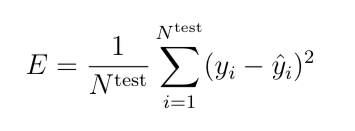

In [ ]:
baseline_df = pd.DataFrame({
    "outer_fold": range(1, len(baseline_errors) + 1),
    "baseline_mse": baseline_errors
})

# get and combine data
combined_df = outer_cv_results_df.merge(df_lr, on="outer_fold", suffixes=('_ann', '_lr'))
combined_df = combined_df.merge(baseline_df, on="outer_fold")
combined_df

In [ ]:
# Save the DataFrame to a CSV file
combined_df.to_csv('data/mse_comparison_data.csv', index=False)
print("Data saved to mse_comparison_data.csv")

In [ ]:
# Read the data from the CSV file
loaded_data = pd.read_csv('data/mse_comparison_data.csv')
print("Data loaded successfully:")
print(loaded_data.head())

In [ ]:
# calculate mean values
ann_mean_mse = combined_df["test_mse_ann"].mean()
ridge_mean_mse = combined_df["test_mse_lr"].mean()
baseline_mean_mse = combined_df["baseline_mse"].mean()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=combined_df["outer_fold"],
    y=combined_df["test_mse_ann"],
    name='ANN Model',
    marker_color='blue'
))

fig.add_trace(go.Bar(
    x=combined_df["outer_fold"],
    y=combined_df["test_mse_lr"],
    name='Ridge Regression',
    marker_color='green'
))

fig.add_trace(go.Bar(
    x=combined_df["outer_fold"],
    y=combined_df["baseline_mse"],
    name='Baseline Model',
    marker_color='red'
))

fig.add_hline(y=ann_mean_mse, line_dash="dash", line_color='blue', 
              annotation_text=f"{ann_mean_mse:.2f}", annotation_position="right")
fig.add_hline(y=ridge_mean_mse, line_dash="dash", line_color='green', 
              annotation_text=f"{ridge_mean_mse:.2f}", annotation_position="right")
fig.add_hline(y=baseline_mean_mse, line_dash="dash", line_color='red', 
              annotation_text=f"{baseline_mean_mse:.2f}", annotation_position="right")

fig.update_layout(
    title="Model Comparison for Best Inner Fold Models",
    xaxis_title="Outer Fold",
    yaxis_title="Mean Squared Error (MSE)",
    barmode='group',  
    template="plotly_white",
    font=dict(size=14),  
    title_font=dict(size=18),  
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=14), dtick=1), 
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),  
    width=800,
    title_x=0.5,
    legend=dict(
        orientation="h",  
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5,
        title_text=None  
    )
)

# Zeige den Plot an
fig.show(config={'toImageButtonOptions': {'scale': 2}})

##### Step 6: Statistical Evaluation

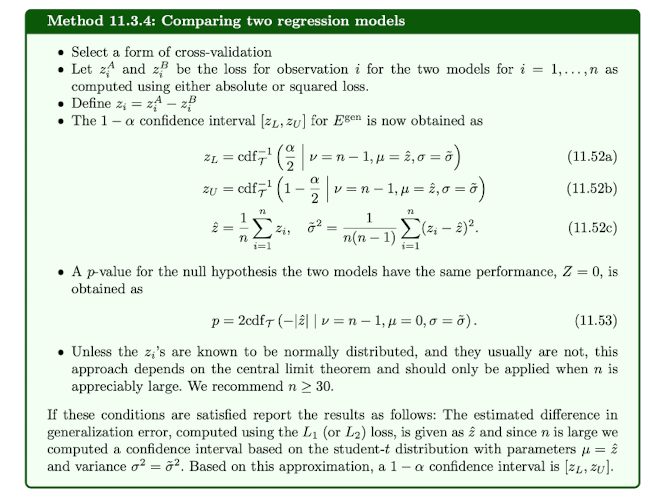

In [ ]:
mse_ann = combined_df["test_mse_ann"].values
mse_lr = combined_df["test_mse_lr"].values
mse_baseline = combined_df["baseline_mse"].values

# Set up comparisons
comparisons = {
    "ANN vs. LR": (mse_ann, mse_lr),
    "ANN vs. Baseline": (mse_ann, mse_baseline),
    "LR vs. Baseline": (mse_lr, mse_baseline)
}

alpha = 0.05  # Confidence level (95%)
n = len(mse_ann)  # Number of outer folds

results = {}

# Perform paired t-test for each comparison
for name, (mse_a, mse_b) in comparisons.items():
    z = mse_a - mse_b  # Pairwise differences
    z_bar = np.mean(z)  # Mean of differences
    sigma_hat_squared = np.sum((z - z_bar)**2) / (n * (n - 1))  # Variance of differences

    # Compute confidence intervals
    t_val = t.ppf(1 - alpha / 2, df=n - 1)  # Two-tailed t-value for confidence interval
    ci_lower = z_bar - t_val * np.sqrt(sigma_hat_squared)
    ci_upper = z_bar + t_val * np.sqrt(sigma_hat_squared)

    # Compute p-value
    t_stat = z_bar / np.sqrt(sigma_hat_squared)
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=n - 1))

    # Store results
    results[name] = {
        "Mean Difference (z_bar)": z_bar,
        "Variance (sigma_hat^2)": sigma_hat_squared,
        "95% CI Lower Bound": ci_lower,
        "95% CI Upper Bound": ci_upper,
        "p-value": p_value
    }

# Display results
for name, result in results.items():
    print(f"\nComparison: {name}")
    print(f"  Mean Difference (z_bar): {result['Mean Difference (z_bar)']:.4f}")
    print(f"  Variance (sigma_hat^2): {result['Variance (sigma_hat^2)']:.4f}")
    print(f"  95% Confidence Interval: [{result['95% CI Lower Bound']:.4f}, {result['95% CI Upper Bound']:.4f}]")
    print(f"  p-value: {result['p-value']:.2e}")